In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.misc.plot import plot_n_components
from magrec import __datapath__

In [4]:
from magrec.misc.load import load_matlab_data

In [5]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ.mat")
B_NV = torch.tensor(mat['Bnv_map'].T)
B_NV.shape  # (39, 141) — notice that it is probably bad to have an odd number of pixels

torch.Size([141, 39])

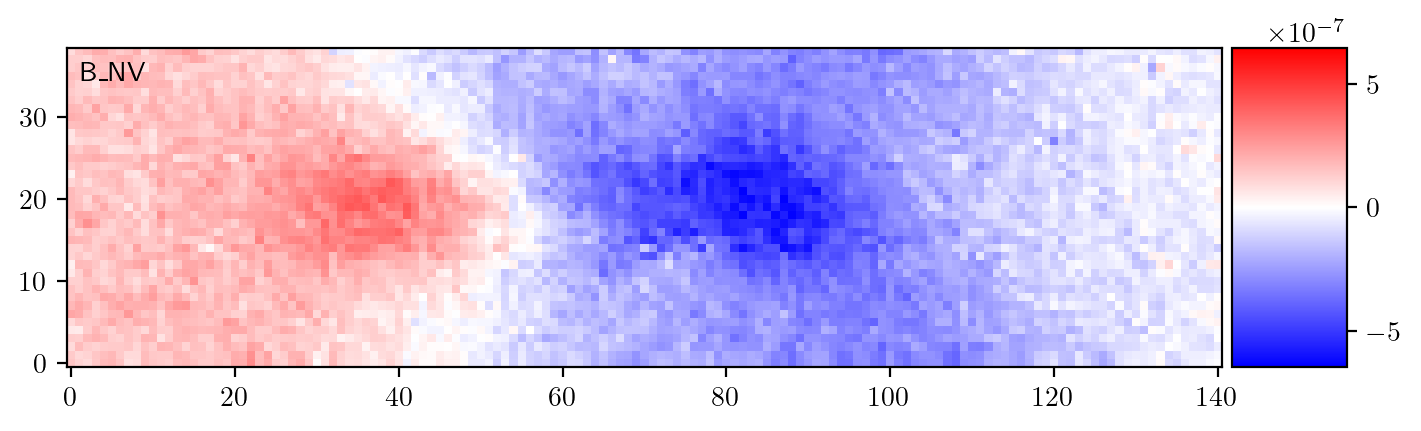

In [6]:
plot_n_components(B_NV, labels=[r'B_NV'], cmap="bwr")

In [7]:
# inspect the coordinate vectors to check for spacing
x_vector = mat["rx_inv"]
y_vector = mat["ry_inv"]

print(np.unique(np.diff(x_vector)))
print(np.unique(np.diff(y_vector)))

[0.01692525 0.01692525 0.01692525 0.01692525 0.01692525 0.01692525
 0.01692525 0.01692525 0.01692525]
[0.02916667 0.02916667 0.02916667 0.02916667 0.02916667 0.02916667
 0.02916667]


In [33]:
# data from inspecting the matlab file  
dx=0.0169  # in μm
dy=0.0292

# data from the .pptx shared by the authors
theta = 54.7  # degrees
phi = 30.0 +90 # degrees

ft = FourierTransform2d(B_NV.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b_NV = ft.forward(B_NV, dim=(-2, -1))

kernel.shape


torch.Size([3, 141, 20])

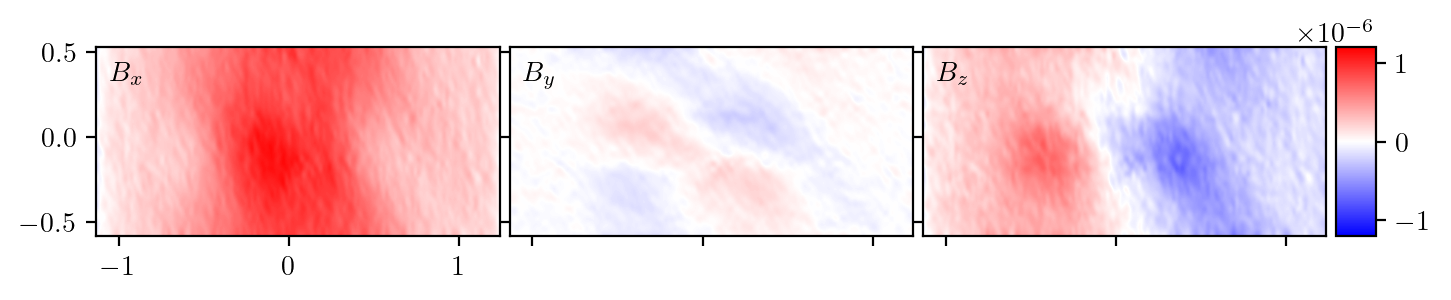

In [41]:

b = torch.einsum("jkl,kl->jkl", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B[0,::] = B[0,::] + 5e-7 

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic", "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()]})

# plot_n_components(B[:,:,40:80], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
# imshow_kwargs={"interpolation": "bicubic", "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()]})


In [11]:
from magrec.prop.Propagator import FourierPadder

In [12]:
padded_B_NV = FourierPadder.pad_reflective2d(B_NV)


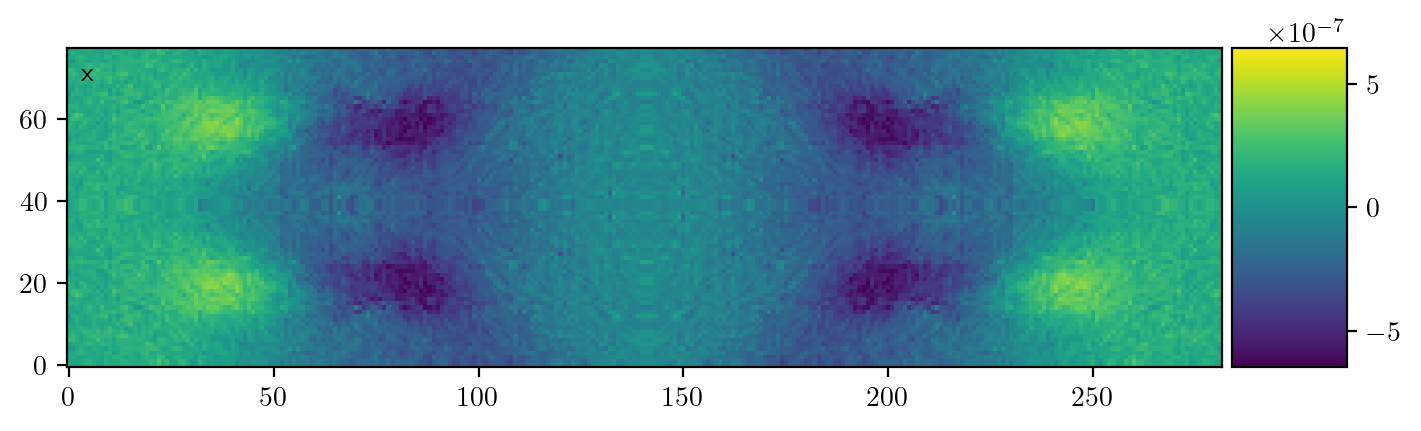

In [13]:
plot_n_components(FourierPadder.pad_reflective2d(B_NV))

In [14]:
# padded_B_NV = FourierPadder.pad_2d(B_NV)
# padded_B_NV = FourierPadder.pad_2d(B_NV, (10,10), 'linear_ramp', plot=True)

ft = FourierTransform2d(padded_B_NV.shape, dx=dx, dy=dy)
b_NV = ft.forward(padded_B_NV, dim=(-2, -1))
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)
b = torch.einsum("cjk,jk->cjk", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B.shape # (3, n_x, n_y) <- this should give real vector field map

torch.Size([3, 282, 78])

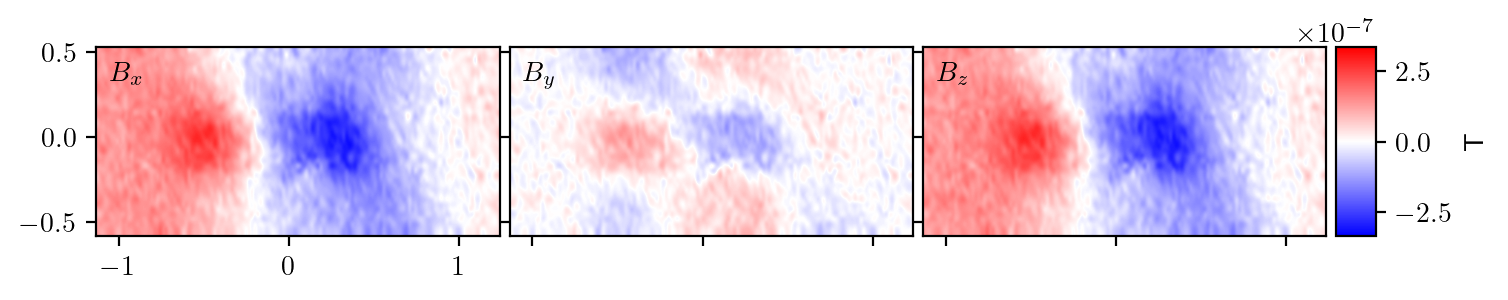

In [15]:
plot_n_components(B[:, :141, :39], symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", units="T",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })

In [132]:
height = 0.015 # in μm
layer_thickness = 0 # put 1 for now to get result per μm
inversion_kernel = MagneticFieldToCurrentInversion2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

Applied a high frequency filter, removing all components smaller than 0.015 um
Applied a high frequency filter, removing all components smaller than 0.015 um


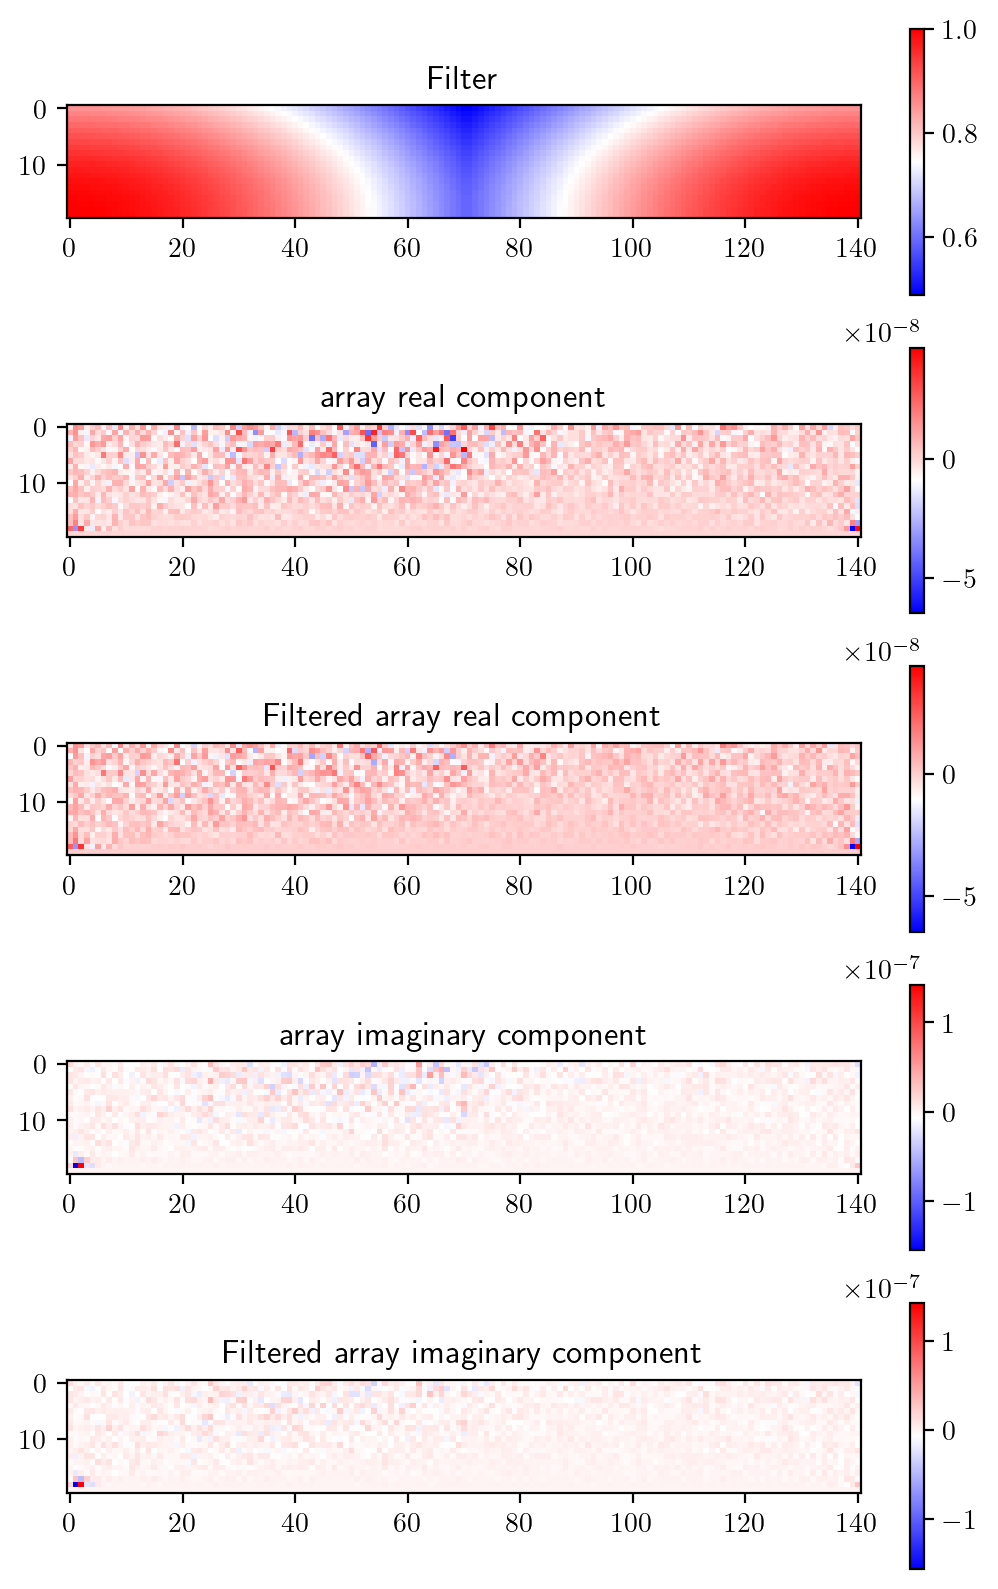

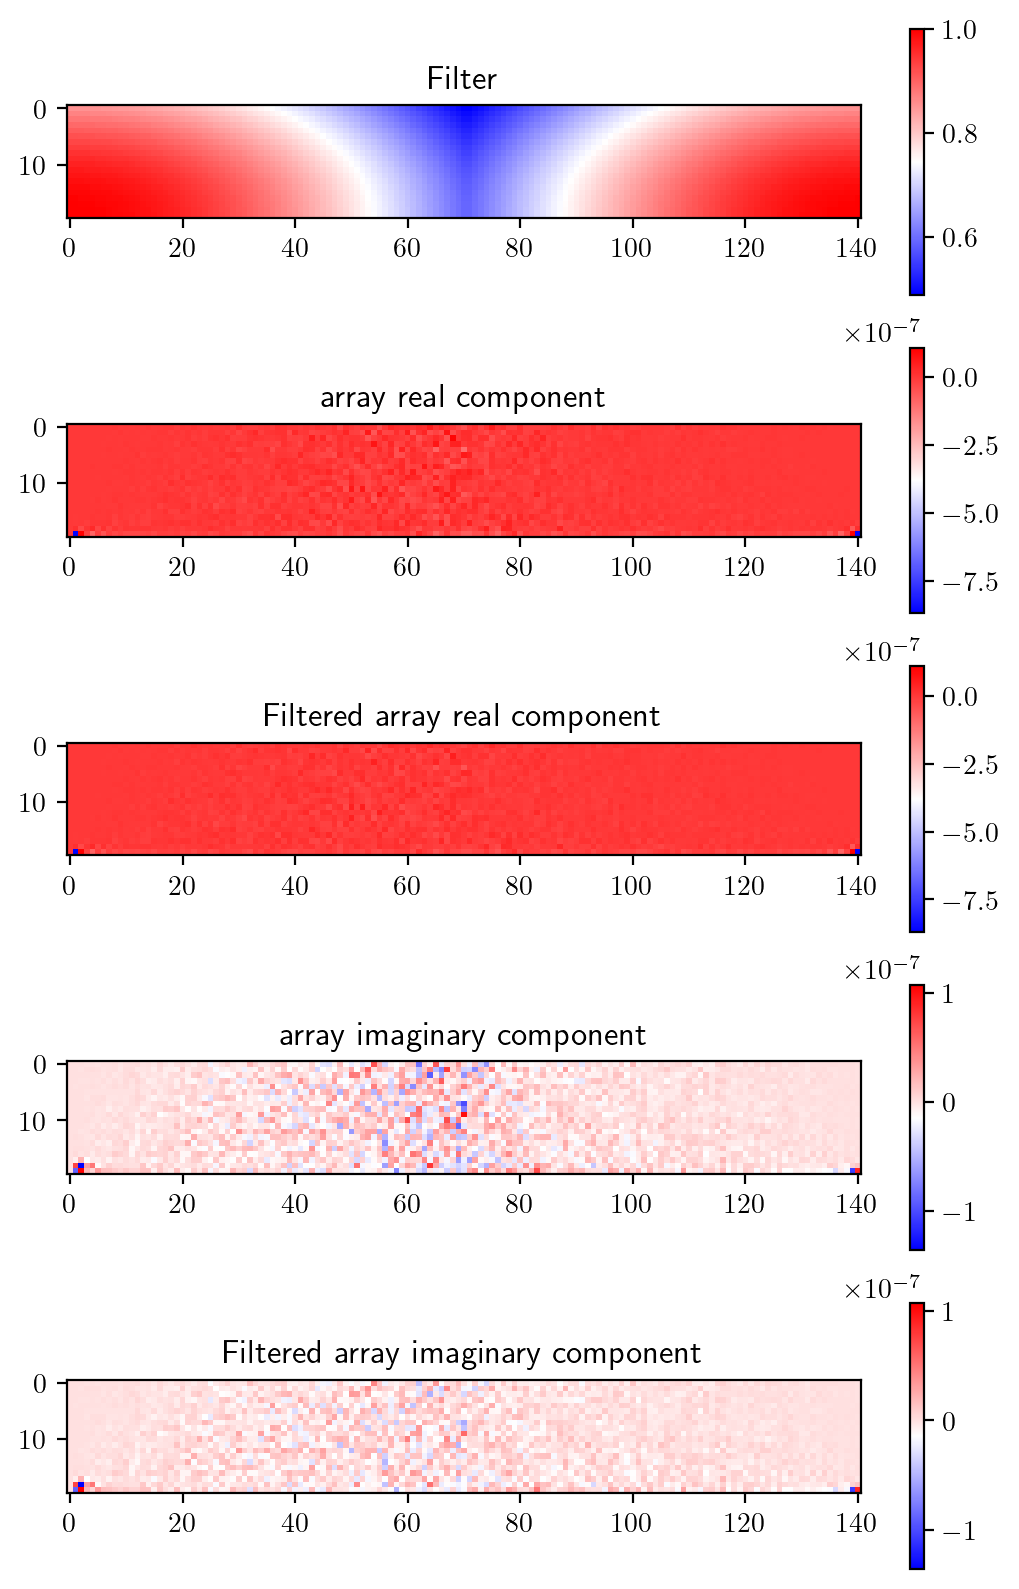

In [135]:
bxby = b[:2, :, :].type(dtype=torch.complex64)
jxjy = torch.einsum('vcjk,cjk->vjk', inversion_kernel, bxby)
jxjy[0,::] = FourierPadder.apply_hanning(jxjy[0,::], ft.k_matrix, height, high_freq_cutoff = height, low_freq_cutoff = None, plot = True)
jxjy[1,::] = FourierPadder.apply_hanning(jxjy[1,::], ft.k_matrix, height, high_freq_cutoff = height, low_freq_cutoff = None, plot = True)
JxJy = ft.backward(jxjy, dim=(-2, -1))

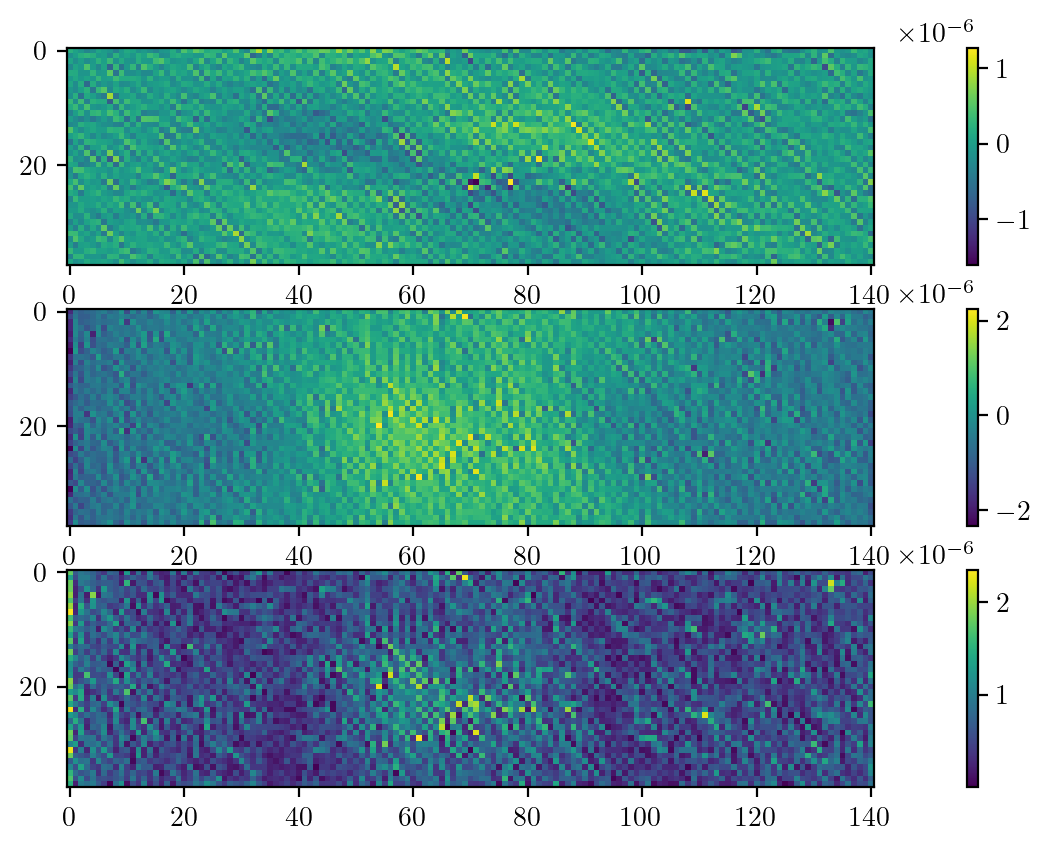

In [134]:
fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(3,1,1)
plt.imshow(np.rot90(JxJy[0,::]))
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(np.rot90(JxJy[1,::]))
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(np.rot90(np.sqrt(JxJy[0,::]**2 + JxJy[1,::]**2)))
plt.colorbar()

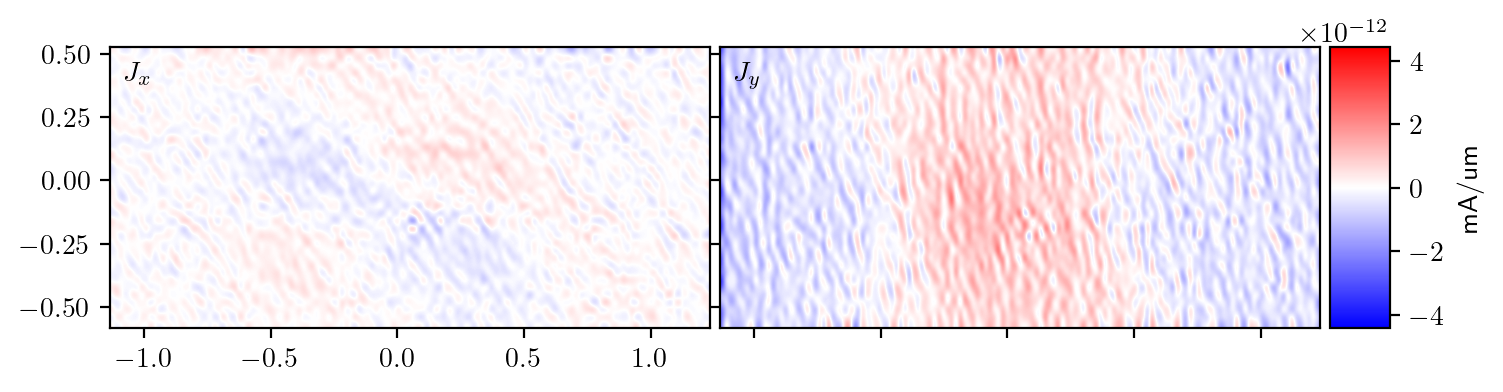

In [117]:
plot_n_components(JxJy * 1e-6, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "extent": [x_vector.min(), x_vector.max(), y_vector.min(), y_vector.max()],
    "interpolation": "bicubic",
    })